In [22]:
using BoundaryValueDiffEq, Plots

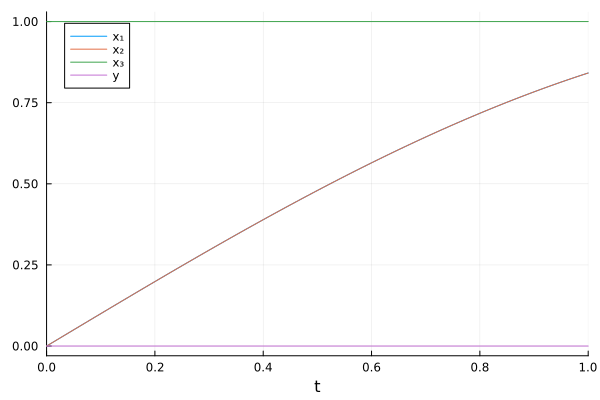

In [23]:
p1(t) = sin(t)
dp1(t) = cos(t)
p2(t) = sin(t)
dp2(t) = cos(t)

function f!(du, u, p, t)
    x1, x2, x3, y = u
    ε = p[1]
    du[1] = (ε + x2 - p2(t)) * y + dp1(t)
    du[2] = dp2(t)
    du[3] = y
    du[4] = (u[1] - p1(t)) * (y - exp(t))
end

# BCs:
# x1(0) = p1(0)
# x2(1) = p2(1)
# x3(0) = 1

function bc!(res, u, p, t)
    res[1] = u[1] - p1(0)
    res[2] = u[2] - p2(1.0)
    res[3] = u[3] - 1.0
end

u0 = [0.0, 0.0, 0.0, 0.0]

tspan = (0.0, 1.0)

fun = BVPFunction(f!, bc!, mass_matrix=[1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 0])

prob = BVProblem(fun, u0, tspan, [1])

sol = solve(prob,
    Ascher4(; zeta=[0.0, 1.0, 0.0], jac_alg=BVPJacobianAlgorithm(AutoForwardDiff()));
    dt=0.01)
plot(sol, labels=["x₁" "x₂" "x₃" "y"])

In [24]:
using Printf

@printf "x1(0) = %.6f (expected %.6f)\n" sol(0)[1] sin(0)
@printf "x2(1) = %.6f (expected %.6f)\n" sol(1)[2] sin(1)
@printf "x3(0) = %.6f (expected %.6f)\n" sol(0)[3] 1.0

x1(0) = 0.000000 (expected 0.000000)
x2(1) = 0.841471 (expected 0.841471)
x3(0) = 1.000000 (expected 1.000000)


In [25]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D

In [26]:
@mtkmodel dae_example begin
    @constants begin
        ε = 1
    end
    @variables begin
        # initialize with only BCs we know at t=0
        # Recall the BCs:
        # x1(0) = p1(0)
        # x2(1) = p2(1)
        # x3(0) = 1
        p1(t)
        p2(t)
        x1(t) = p1
        x2(t) = 0
        x3(t) = 1
        y(t) = 0
    end
    @equations begin
        # DAE equations
        p1 ~ sin(t)
        p2 ~ sin(t)
        D(x1) ~ (ε + x2 - p2) * y + D(p1)
        D(x2) ~ D(p2)
        D(x3) ~ y
        0 ~ (x1 - p1) * (y - exp(t))
    end
end

ModelingToolkit.Model{typeof(__dae_example__), Dict{Symbol, Any}}(Main.__dae_example__, Dict{Symbol, Any}(:metadata => Dict{Symbol, Any}(), :variables => Dict{Symbol, Dict{Symbol, Any}}(:p2 => Dict(:type => Real), :y => Dict(:default => 0, :type => Real), :x2 => Dict(:default => 0, :type => Real), :x3 => Dict(:default => 1, :type => Real), :p1 => Dict(:type => Real), :x1 => Dict(:default => :p1, :type => Real)), :kwargs => Dict{Symbol, Dict}(:p2 => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :y => Dict{Symbol, Any}(:value => 0, :type => Real), :x2 => Dict{Symbol, Any}(:value => 0, :type => Real), :x3 => Dict{Symbol, Any}(:value => 1, :type => Real), :ε => Dict{Symbol, Any}(:value => 1, :type => Real), :p1 => Dict{Symbol, Union{Nothing, DataType}}(:value => nothing, :type => Real), :x1 => Dict{Symbol, Any}(:value => :p1, :type => Real)), :independent_variable => :t, :constants => Dict{Symbol, Dict{Symbol, Any}}(:ε => Dict(:default => 1, :type => Real)), :eq

In [27]:
@mtkcompile sys = dae_example()

Model sys:
Equations (4):
  4 standard: see equations(sys)
Unknowns (4): see unknowns(sys)
  y(t) [defaults to 0]
  x3(t) [defaults to 1]
  x2(t) [defaults to 0]
  x1(t) [defaults to p1(t)]
Parameters (1): see parameters(sys)
  ε [defaults to 1]
Observed (4): see observed(sys)

In [28]:
mtkprob = BVProblem(sys, [], tspan)

BVProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: true
timespan: (0.0, 1.0)
u0: 4-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0

In [29]:
mtksol = solve(mtkprob, MIRK4(), dt=0.01)

retcode: Success
Interpolation: MIRK Order 4 Interpolation
t: 101-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 0.89
 0.9
 0.91
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0
u: 101-element Vector{Vector{Float64}}:
 [-2.272991878025853e-17, 1.0, 3.062219081364504e-17, -2.1062152760352804e-17]
 [-4.1869994979534895e-10, 0.9999999999979029, 0.009999833334201446, 0.009999832911214835]
 [-1.6953821001106981e-9, 0.9999999999873211, 0.019998666693402608, 0.01999866497414234]
 [-3.854282619427052e-9, 0.999999999959553, 0.02999550020259993, 0.029995496275537836]
 [-6.919094240682844e-9, 0.9999999999056571, 0.03998933418677315, 0.039989327101714815]
 [-1.0912923730520771e-8, 0.9999999998164578, 0.04997916927085204, 0.04997915803852725]
 [-1.5858248858370508e-8, 0.9999999996825518, 0.059964006479653005, 0.059963990071322276]
 [-2.177687491239038e-8, 0.9999999994943142, 0.06994284733777587, 0.06994282468485347]
 [-2.868989079182224e

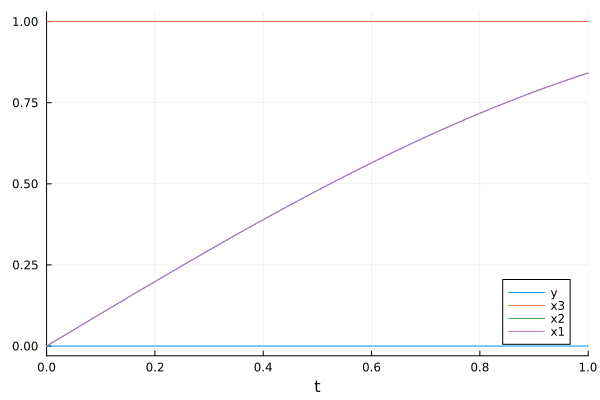

In [30]:
plot(mtksol)

In [34]:
@show unknowns(sys)

unknowns(sys) = SymbolicUtils.BasicSymbolic{Real}[y(t), x3(t), x2(t), x1(t)]


4-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 y(t)
 x3(t)
 x2(t)
 x1(t)

In [35]:
@printf "x1(0) = %.6f (expected %.6f)\n" mtksol(0)[4] sin(0)
@printf "x2(1) = %.6f (expected %.6f)\n" mtksol(1)[3] sin(1)
@printf "x3(0) = %.6f (expected %.6f)\n" mtksol(0)[2] 1.0

x1(0) = -0.000000 (expected 0.000000)
x2(1) = 0.841471 (expected 0.841471)
x3(0) = 1.000000 (expected 1.000000)
